### Logistic Regression

In [3]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV 
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import (confusion_matrix, roc_curve, auc, classification_report, 
ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay, PredictionErrorDisplay)
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.utils.discovery import all_displays
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import LearningCurveDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score

from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.inspection import permutation_importance

from yellowbrick.classifier import DiscriminationThreshold
from yellowbrick.classifier.threshold import discrimination_threshold

import optuna
import flaml

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv("training.csv")
test = pd.read_csv("testing.csv")

In [5]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Honorific
0,1,0,3,1,young adult,1,0,2.692582,0,S,mr
1,2,1,1,0,adult,1,0,8.442944,1,C,mrs
2,3,1,3,0,adult,0,0,2.815138,0,S,miss
3,4,1,1,0,adult,1,0,7.286975,1,S,mrs
4,5,0,3,1,adult,0,0,2.837252,0,S,mr


### Onehot Encoding

In [7]:
encoder_class = OneHotEncoder(sparse_output=False)
encoder_age = OneHotEncoder(sparse_output=False)
encoder_emb = OneHotEncoder(sparse_output=False)
encoder_hon = OneHotEncoder(sparse_output=False)

In [8]:
encoded_class = encoder_class.fit_transform(train[['Pclass']]).astype(int)
encoded_age = encoder_age.fit_transform(train[['Age']]).astype(int)
encoded_emb = encoder_emb.fit_transform(train[['Embarked']]).astype(int)
encoded_hon = encoder_hon.fit_transform(train[['Honorific']]).astype(int)

In [9]:
encoded_class_df = pd.DataFrame(
    encoded_class,
    columns=encoder_class.get_feature_names_out(['Pclass'])
)

encoded_age_df = pd.DataFrame(
    encoded_age,
    columns=encoder_age.get_feature_names_out(['Age'])
)

encoded_emb_df = pd.DataFrame(
    encoded_emb,
    columns=encoder_emb.get_feature_names_out(['Embarked'])
)

encoded_hon_df = pd.DataFrame(
    encoded_hon,
    columns=encoder_hon.get_feature_names_out(['Honorific'])
)

In [10]:
encoded_df = pd.concat([encoded_class_df, encoded_age_df, encoded_emb_df, encoded_hon_df], axis=1)

In [11]:
train = pd.concat([train, encoded_df], axis = 1)

In [12]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,...,Age_teen,Age_young adult,Embarked_C,Embarked_Q,Embarked_S,Honorific_miss,Honorific_mr,Honorific_mrs,Honorific_other,Honorific_rank
0,1,0,3,1,young adult,1,0,2.692582,0,S,...,0,1,0,0,1,0,1,0,0,0
1,2,1,1,0,adult,1,0,8.442944,1,C,...,0,0,1,0,0,0,0,1,0,0
2,3,1,3,0,adult,0,0,2.815138,0,S,...,0,0,0,0,1,1,0,0,0,0
3,4,1,1,0,adult,1,0,7.286975,1,S,...,0,0,0,0,1,0,0,1,0,0
4,5,0,3,1,adult,0,0,2.837252,0,S,...,0,0,0,0,1,0,1,0,0,0


In [13]:
encoded_class = encoder_class.fit_transform(test[['Pclass']]).astype(int)
encoded_age = encoder_age.fit_transform(test[['Age']]).astype(int)
encoded_emb = encoder_emb.fit_transform(test[['Embarked']]).astype(int)
encoded_hon = encoder_hon.fit_transform(test[['Honorific']]).astype(int)

In [14]:
encoded_class_df = pd.DataFrame(
    encoded_class,
    columns=encoder_class.get_feature_names_out(['Pclass'])
)

encoded_age_df = pd.DataFrame(
    encoded_age,
    columns=encoder_age.get_feature_names_out(['Age'])
)

encoded_emb_df = pd.DataFrame(
    encoded_emb,
    columns=encoder_emb.get_feature_names_out(['Embarked'])
)

encoded_hon_df = pd.DataFrame(
    encoded_hon,
    columns=encoder_hon.get_feature_names_out(['Honorific'])
)

In [15]:
encoded_df = pd.concat([encoded_class_df, encoded_age_df, encoded_emb_df, encoded_hon_df], axis=1)

In [16]:
test = pd.concat([test, encoded_df], axis = 1)

In [17]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Honorific,...,Age_teen,Age_young adult,Embarked_C,Embarked_Q,Embarked_S,Honorific_miss,Honorific_mr,Honorific_mrs,Honorific_other,Honorific_rank
0,892,3,1,adult,0,0,2.798071,0,Q,mr,...,0,0,0,1,0,0,1,0,0,0
1,893,3,0,adult,1,0,2.645751,0,S,mrs,...,0,0,0,0,1,0,0,1,0,0
2,894,2,1,senior,0,0,3.112475,0,Q,mr,...,0,0,0,1,0,0,1,0,0,0
3,895,3,1,adult,0,0,2.943213,0,S,mr,...,0,0,0,0,1,0,1,0,0,0
4,896,3,0,young adult,1,1,3.505353,0,S,mrs,...,0,1,0,0,1,0,0,1,0,0


### Train-Test Datasets

Split the training data set into two, a new training set and a test set to validate the model, and then use the model to predict on the provided training set. 

In [19]:
X = train.drop(columns=['PassengerId', 'Pclass', 'Age', 'Honorific', 'Embarked', 'Survived'])
y = train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
test_id = test['PassengerId']
test = test.drop(columns=['PassengerId', 'Pclass', 'Age', 'Honorific', 'Embarked'])

### Model

#### Optuna Hypertuned

In [22]:
def objective(trial):
    # Define hyperparameters to optimize
    params = {
        'C': trial.suggest_loguniform('C', 1e-5, 1e5),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'saga']),
        'max_iter': trial.suggest_int('max_iter', 10000, 100000),
        'l1_ratio': trial.suggest_uniform('l1_ratio', 0, 1),
    }
    
    # Get penalty based on solver
    if params['solver'] == 'saga':
        params['penalty'] = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
    else:
        params['penalty'] = 'l2'  # lbfgs only supports l2 penalty
    
    # Create and train model
    model = LogisticRegression(random_state=42, **params)
    model.fit(X_train, y_train)
    
    # Predict and calculate metrics
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate multiple metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Use ROC-AUC as the primary optimization metric
    return roc_auc

In [23]:
def optimize_model(n_trials=100):
    # Create study
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    
    # Print results
    print("\nStudy statistics:")
    print(f"  Number of finished trials: {len(study.trials)}")
    print(f"  Best trial:")
    
    trial = study.best_trial
    print(f"  ROC-AUC: {trial.value:.4f}")
    print("\nBest hyperparameters:")
    for key, value in trial.params.items():
        print(f"  {key}: {value}")
    
    best_model = LogisticRegression(random_state=42, **study.best_params)
    best_model.fit(X_train, y_train)
    
    # Evaluate final model
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    print("\nFinal model performance:")
    print(f"  Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"  ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    print(f"  Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"  Recall: {recall_score(y_test, y_pred):.4f}")
    
    return best_model, study

In [24]:
best_model, study = optimize_model(n_trials=150)

[I 2024-12-21 17:22:44,004] A new study created in memory with name: no-name-8c9e9fe8-4371-4d8c-b40e-64153fb9dbb1
[I 2024-12-21 17:22:44,011] Trial 0 finished with value: 0.8829115739943765 and parameters: {'C': 0.0939310598127739, 'solver': 'lbfgs', 'max_iter': 77594, 'l1_ratio': 0.39491245331429403}. Best is trial 0 with value: 0.8829115739943765.
[I 2024-12-21 17:22:44,201] Trial 1 finished with value: 0.8722384805187353 and parameters: {'C': 14.82559468830652, 'solver': 'saga', 'max_iter': 96232, 'l1_ratio': 0.8428612691742012, 'penalty': 'l2'}. Best is trial 0 with value: 0.8829115739943765.
[I 2024-12-21 17:22:44,211] Trial 2 finished with value: 0.5 and parameters: {'C': 1.3814490606401118e-05, 'solver': 'saga', 'max_iter': 85878, 'l1_ratio': 0.6638674104058551, 'penalty': 'elasticnet'}. Best is trial 0 with value: 0.8829115739943765.
[I 2024-12-21 17:22:44,236] Trial 3 finished with value: 0.8717794227348367 and parameters: {'C': 220.9032602229706, 'solver': 'lbfgs', 'max_iter'


Study statistics:
  Number of finished trials: 150
  Best trial:
  ROC-AUC: 0.8903

Best hyperparameters:
  C: 0.13922228827007782
  solver: saga
  max_iter: 99990
  l1_ratio: 0.9644740947505763
  penalty: elasticnet

Final model performance:
  Accuracy: 0.8022
  ROC-AUC: 0.8903
  Precision: 0.7685
  Recall: 0.7477


In [25]:
best_model

LogisticRegression(C=0.13922228827007782, l1_ratio=0.9644740947505763,
                   max_iter=99990, penalty='elasticnet', random_state=42,
                   solver='saga')

In [26]:
y_pred = best_model.predict(X_test)

In [27]:
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       157
           1       0.77      0.75      0.76       111

    accuracy                           0.80       268
   macro avg       0.80      0.79      0.80       268
weighted avg       0.80      0.80      0.80       268



In [28]:
cm = confusion_matrix(y_test, y_pred)

Text(0.5, 1.0, 'All Variables')

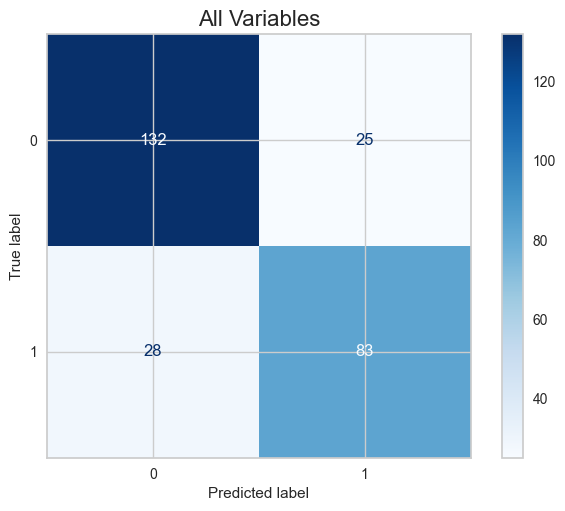

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('All Variables', fontsize=16)

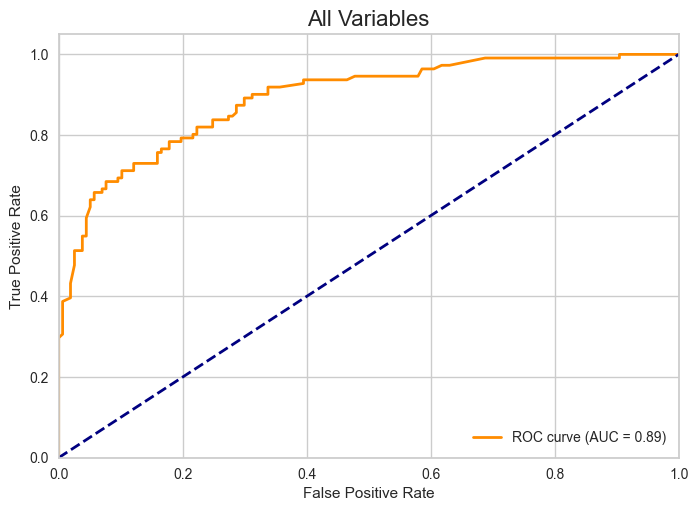

In [30]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('All Variables', fontsize=16)
plt.legend(loc="lower right")

Text(0.5, 1.0, 'All Variables')

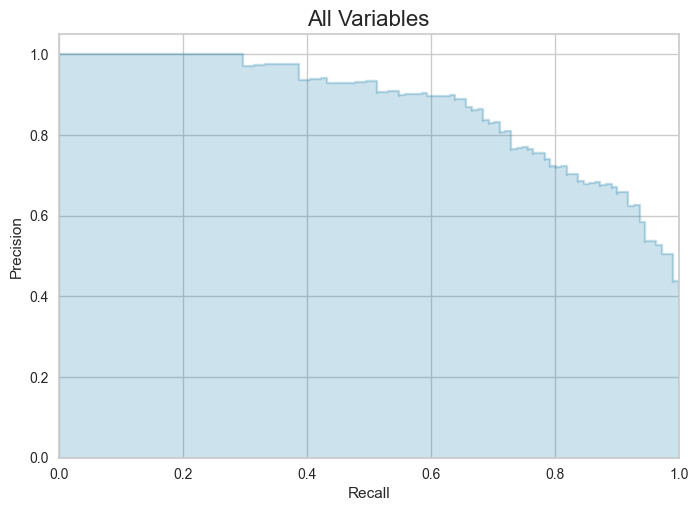

In [31]:
# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, best_model.predict_proba(X_test)[:, 1])

# Plot Precision-Recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('All Variables', fontsize=16)

In [32]:
y_valid = best_model.predict(test)

In [65]:
y_valid = pd.Series(y_valid, name='Survived')
submission = pd.concat([test_id, y_valid], axis=1)

In [69]:
submission.to_csv("logistic_regression_optuna.csv", index=False)